In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories.
The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

## Install Datasets and Upgrade TensorFlow

To ensure we can download the latest version of the `oxford_flowers102` dataset, let's first install both `tensorflow-datasets` and `tfds-nightly`.
* `tensorflow-datasets` is the stable version that is released on a cadence of every few months
* `tfds-nightly` is released every day and has the latest version of the datasets

We'll also upgrade TensorFlow to ensure we have a version that is compatible with the latest version of the dataset.

In [1]:
#%pip --no-cache-dir install tensorflow-datasets --user
%pip --no-cache-dir install tfds-nightly --user

     |████████████████████████████████| 5.3MB 4.8MB/s eta 0:00:01     |█████▍                          | 890kB 4.8MB/s eta 0:00:01
     |████████████████████████████████| 163kB 29.3MB/s eta 0:00:01
     |████████████████████████████████| 143kB 29.7MB/s eta 0:00:01
     |████████████████████████████████| 102kB 28.5MB/s ta 0:00:01
     |████████████████████████████████| 419kB 29.9MB/s eta 0:00:01
ERROR: tensorflow-metadata 0.14.0 has requirement protobuf<4,>=3.7, but you'll have protobuf 4.21.12 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


<b> After the above installations have finished be sure to restart the kernel. You can do this by going to Kernel > Restart. </b>

In [1]:
#!pip --no-cache-dir install tensorflow --upgrade --user
!pip install grpcio
!pip install tensorflow-gpu --upgrade --user
#!pip install tensorflow-datasets==3.2.1 --upgrade --user

     |████████████████████████████████| 587.6MB 23.5MB/s eta 0:00:01     |████████████████████████████████| 588.3MB 23.5MB/s eta 0:00:01     |████████████████████████████████| 588.3MB 18kB/s 
     |████████████████████████████████| 51kB 10.6MB/s eta 0:00:01
     |████████████████████████████████| 133kB 30.0MB/s eta 0:00:01
     |████████████████████████████████| 6.0MB 22.5MB/s eta 0:00:01     |██████▎                         | 1.2MB 22.5MB/s eta 0:00:01     |██████████████████████████████▌ | 5.7MB 22.5MB/s eta 0:00:01
     |████████████████████████████████| 4.8MB 42.9MB/s eta 0:00:01     |█                               | 143kB 42.9MB/s eta 0:00:01     |████████████▍                   | 1.9MB 42.9MB/s eta 0:00:01
     |████████████████████████████████| 21.5MB 128kB/s  eta 0:00:01    |██████████▏                     | 6.9MB 26.6MB/s eta 0:00:01     |█████████████▊                  | 9.2MB 26.6MB/s eta 0:00:01     |███████████████▎                | 10.3MB 26.6MB/s eta 0:00:01     |██████

In [2]:
# Import TensorFlow 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

# Ignore some warnings that are not relevant (you can remove this if you prefer)
import warnings
warnings.filterwarnings('ignore')

# Check tensorflow version
print(tf.version.VERSION)

2.11.0


In [3]:
# TODO: Make all other necessary imports.
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
logging.getLogger("tensorflow").setLevel(logging.ERROR)

print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.11.0
	• tf.keras version: 2.11.0
	• GPU device not found. Running on CPU


In [4]:
# Some other recommended settings:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [5]:
# TODO: Load the dataset with TensorFlow Datasets. Hint: use tfds.load()

(training_set,test_set,validation_set), dataset_info = tfds.load('oxford_flowers102',\
        split = ['test[:80%]', 'test[80%:90%] + train', 'test[90%:] + validation'], \
        as_supervised=True, with_info=True, shuffle_files=True)
                                                                                                  
dataset_info  

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

## Explore the Dataset

In [6]:
# TODO: Get the number of examples in each set from the dataset info.
print("Train set size: ", len(training_set))
print("Test set size: ", len(test_set))  
print("Valid set size: ", len(validation_set))

total_examples = dataset_info.splits['train'].num_examples + dataset_info.splits['test'].num_examples + \
                dataset_info.splits['validation'].num_examples

print("Total number of examples is: ", total_examples)

# TODO: Get the number of classes in the dataset from the dataset info.
num_classes = dataset_info.features['label'].num_classes
print('There are {:,} classes in our dataset'.format(num_classes))

'''
# Split in each dataset
train_split = len(training_set)/(len(training_set)+len(test_set)+len(validation_set))
test_split = len(test_set)/(len(training_set)+len(test_set)+len(validation_set))
validation_split = 1 - train_split -test_split
'''

Train set size:  4919
Test set size:  1635
Valid set size:  1635
Total number of examples is:  8189
There are 102 classes in our dataset


'\n# Split in each dataset\ntrain_split = len(training_set)/(len(training_set)+len(test_set)+len(validation_set))\ntest_split = len(test_set)/(len(training_set)+len(test_set)+len(validation_set))\nvalidation_split = 1 - train_split -test_split\n'

In [7]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for image, label in training_set.take(3):
    print('The image has shape of :', image.shape)     
    print('The label of the images is:', label.numpy()) 
    print('\n')

The image has shape of : (500, 667, 3)
The label of the images is: 95


The image has shape of : (500, 752, 3)
The label of the images is: 72


The image has shape of : (500, 576, 3)
The label of the images is: 49




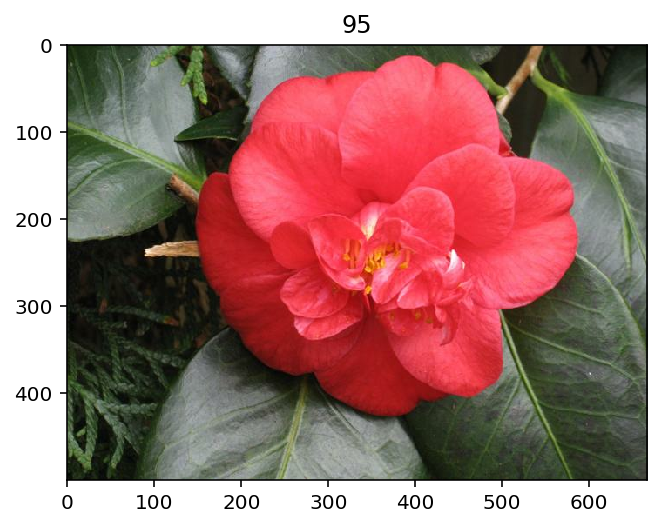

In [8]:
# TODO: Plot 1 image from the training set. 
for image,label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()
    
# Set the title of the plot to the corresponding image label. 
plt.imshow(image)
plt.title(label)
plt.show()

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [5]:
import json

with open('label_map.json', 'r') as f:
    class_names = json.load(f)
print(class_names)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

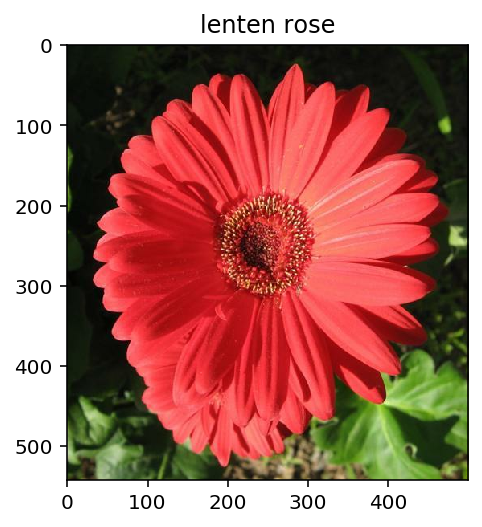

In [10]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 

for image,label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

label = class_names[str(label)]
    
plt.imshow(image)
plt.title(label)
plt.show()

## Create Pipeline

In [11]:
# TODO: Create a pipeline for each set.

batch_size = 32
image_size = 224

num_training_examples = len(training_set)

@tf.autograph.experimental.do_not_convert
def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label

training_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation_set.map(format_image).batch(batch_size).prefetch(1)
testing_batches = test_set.map(format_image).batch(batch_size).prefetch(1)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier.

In [24]:
from workspace_utils import active_session
tf.autograph.set_verbosity(0)
# TODO: Build and train your network.

# Build the network

# Load pre-trained model
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))

# Freeze the model
feature_extractor.trainable = False

# Build the model
tf.keras.backend.clear_session()


model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(102, activation = 'softmax')
])

model.summary()

with active_session():
    # Train the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    EPOCHS = 8

    history = model.fit_generator(training_batches,
                                  epochs=EPOCHS,
                                  validation_data=validation_batches)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/8
154/154 [==============================] - 131s 813ms/step - loss: 2.2132 - accuracy: 0.5428 - val_loss: 1.1429 - val_accuracy: 0.7670
Epoch 2/8
154/154 [==============================] - 126s 809ms/step - loss: 0.6330 - accuracy: 0.8853 - val_loss: 0.7159 - val_accuracy: 0.8544
Epoch 3/8
154/154 [==============================] - 125s 808ms/step - loss: 0.3568 - accuracy: 0.9435 - val_loss: 0.6037 - val_accuracy: 0.8624
E

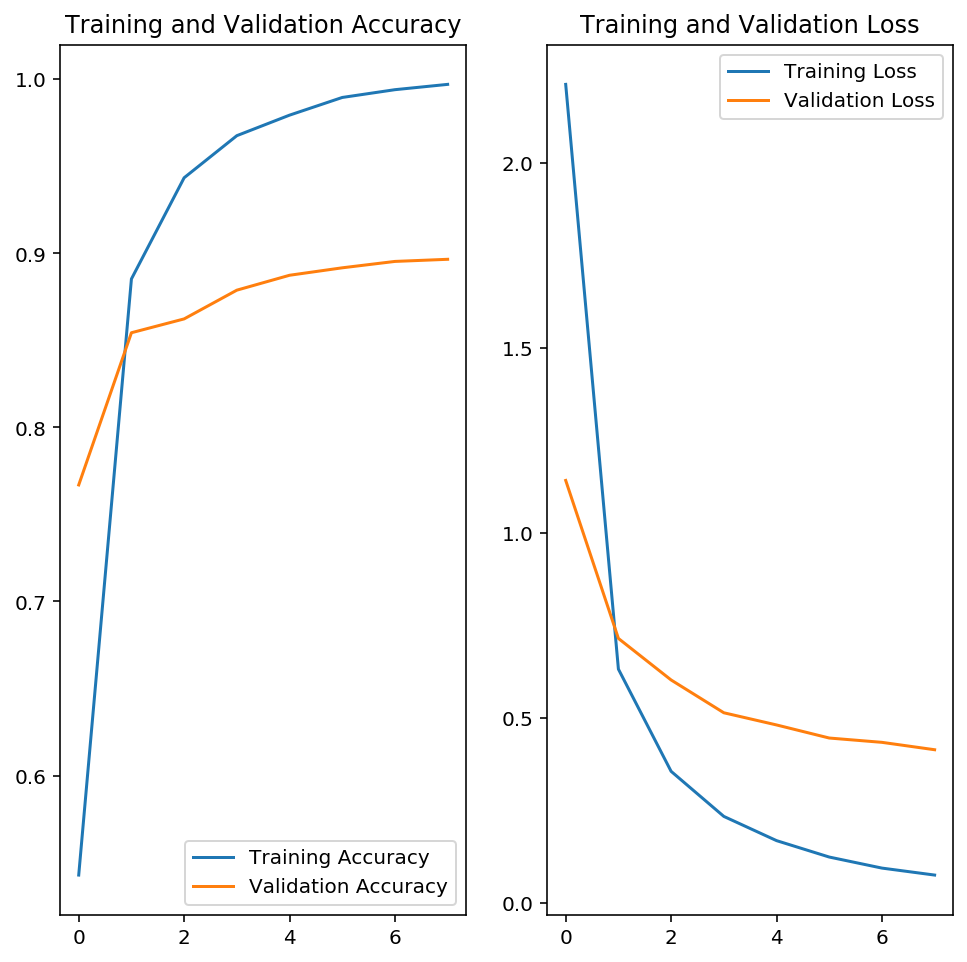

In [25]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [26]:
# TODO: Print the loss and accuracy values achieved on the entire test set.

loss, accuracy = model.evaluate(testing_batches)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

52/52 [==============================] - 31s 589ms/step - loss: 0.4649 - accuracy: 0.8758

Loss on the TEST Set: 0.465
Accuracy on the TEST Set: 87.584%


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [28]:
# TODO: Save your trained model as a Keras model.

import time

t = time.time()

saved_keras_model_filepath = './{}.h5'.format(int(t))

model.save(saved_keras_model_filepath, overwrite=False)

## Load the Keras Model

Load the Keras model you saved above.

In [7]:
# TODO: Load the Keras model

saved_keras_model_filepath = './1673461039.h5'

reloaded_keras_model = tf.keras.models.load_model(saved_keras_model_filepath, custom_objects={'KerasLayer':hub.KerasLayer})

reloaded_keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


# Inference for Classification

Now we will write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```


### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

In [29]:
# TODO: Create the process_image function
image_size = 224

def process_image(test_image):
    image_tensor = tf.cast(test_image, tf.float32)
    image_resized = tf.image.resize(image_tensor, (image_size, image_size))
    image_resized /= 255
    final_image = image_resized.numpy().squeeze()
    return final_image

To check your `process_image` function, there are 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by `process_image` function. If the `process_image` function works, the plotted image should be the correct size. 

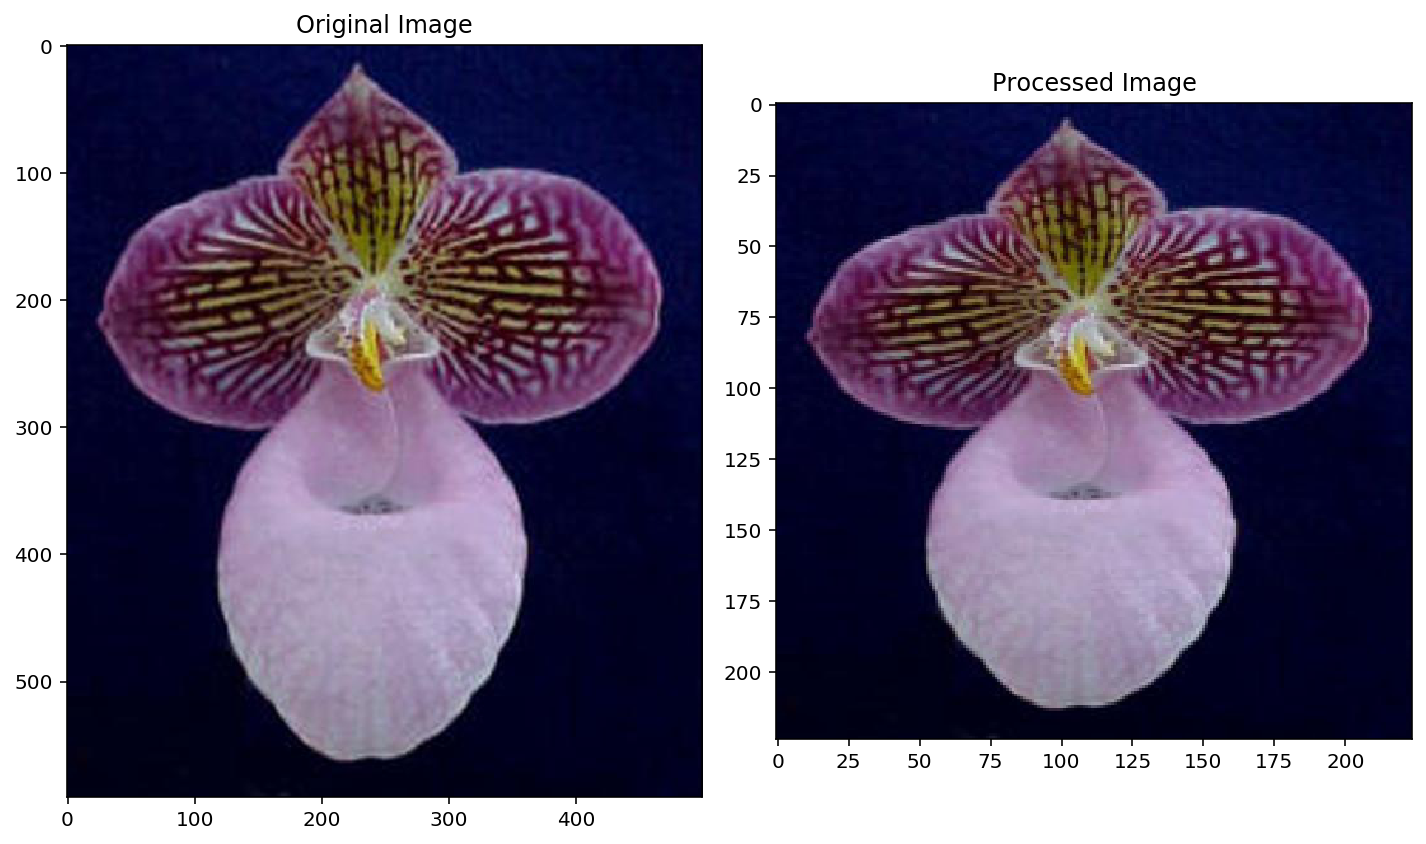

In [92]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [94]:
# TODO: Create the predict function
from PIL import Image

def predict(image_path, model, top_k):
        image = Image.open(image_path)
        np_image = np.asarray(image)
        processed_image = process_image(np_image)
        input_image = np.expand_dims(processed_image, axis=0)
        #print(type(input_image), input_image.shape)
        ps = model.predict(input_image)
        #print(ps)
        #print(type(ps))
                       
        probs = np.sort(ps[0])[-top_k:]       
        probs_list = list(probs)
        probs_list.reverse()
        
        label_indices = (-ps[0]).argsort()[:top_k] 
        label_indices = label_indices.tolist()
        classes = [class_names[str(i+1)] for i in label_indices]
        #print(classes)
        output = probs_list, classes
        #print(output)
        return output

In [99]:
predict(image_path, reloaded_keras_model, 5)

1/1 [==============================] - 0s 48ms/step


([0.99959725, 0.00011855305, 5.1529492e-05, 5.0408835e-05, 4.5767163e-05],
 ['hard-leaved pocket orchid',
  'peruvian lily',
  'tiger lily',
  'passion flower',
  'anthurium'])

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check the predictions, there are 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

1/1 [==============================] - 0s 47ms/step
[0.9986247, 0.0004127756, 9.840279e-05, 9.540736e-05, 9.000818e-05]
['wild pansy', 'balloon flower', 'primula', 'clematis', 'tree mallow']


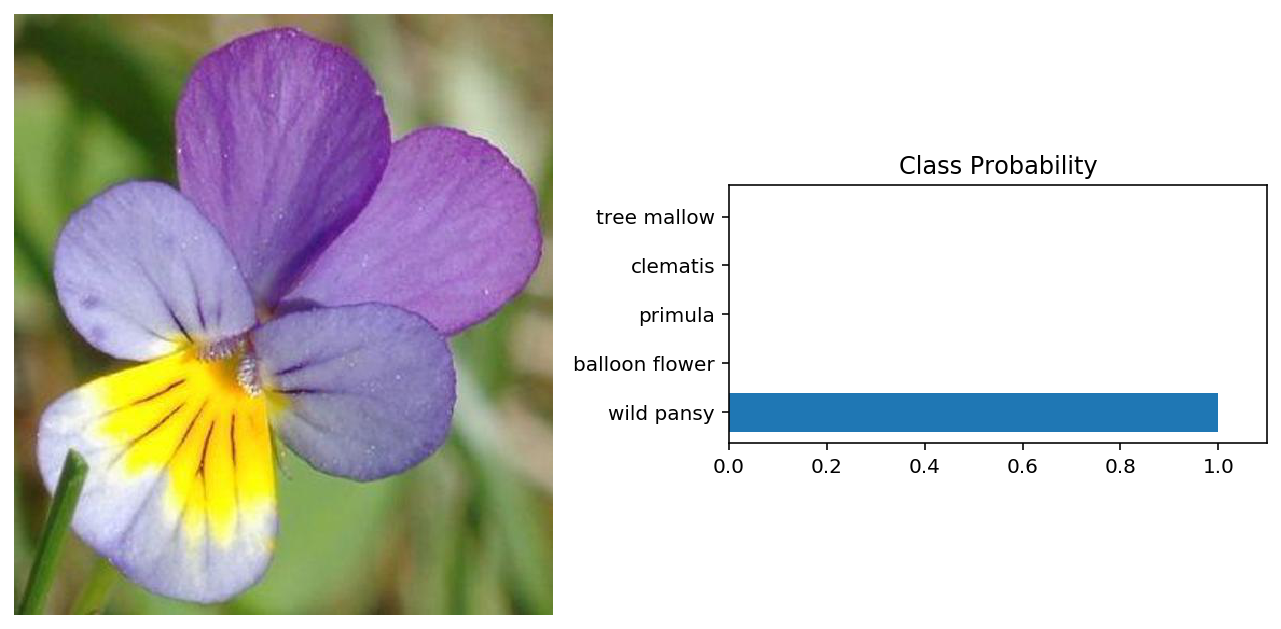

In [100]:
# TODO: Plot the input image along with the top 5 classes
image_path = './test_images/wild_pansy.jpg'
prob, label = predict(image_path, reloaded_keras_model, 5)
print(prob)
print(label)

img = Image.open(image_path)

fig, (ax1, ax2) = plt.subplots(figsize=(9,12), ncols=2)
ax1.imshow(img, cmap = plt.cm.binary)
ax1.axis('off')

ax2.barh(label, prob)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(5))
ax2.set_yticklabels(label)
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()